In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Ford.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_B-Max,Seri_C-Max,Seri_Escort,...,Model_2.0 XR,Model_2.3 RS,Model_2.5 Ghia,Model_4.6 GT,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,460000,0.090909,-0.166667,-0.826923,-0.674157,9.0,3.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,480000,0.272727,-0.194444,0.000000,0.187266,0.0,4.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,899000,0.636364,1.611111,-0.298077,0.037453,3.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,399000,0.000000,-0.888889,-0.778846,-0.089888,4.0,2.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,85000,-1.727273,-0.027778,0.153846,0.898876,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_12696\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,67956.765123,4.884059e+09,69886.040473,37826.196922


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 20:55:09,207] A new study created in memory with name: no-name-0cc9541a-9912-43fa-b016-a395e9545a14
[I 2023-05-23 20:55:09,411] Trial 1 finished with value: 320400.8660309823 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.05321615750615873, 'max_depth': 4, 'min_child_weight': 223}. Best is trial 1 with value: 320400.8660309823.
[I 2023-05-23 20:55:09,443] Trial 2 finished with value: 463493.45064875274 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.00957448664813239, 'max_depth': 8, 'min_child_weight': 168}. Best is trial 1 with value: 320400.8660309823.
[I 2023-05-23 20:55:09,445] Trial 0 finished with value: 504359.56269058964 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.0001202095859240176, 'max_depth': 12, 'min_child_weight': 135}. Best is trial 1 with value: 320400.8660309823.
[I 2023-05-23 20:55:09,446] Trial 6 finished with value: 502995.64222265827 and parameters: {'c

[I 2023-05-23 20:55:10,881] Trial 32 finished with value: 112355.19016981506 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.4945561688767616, 'max_depth': 11, 'min_child_weight': 210}. Best is trial 25 with value: 97683.96729932021.
[I 2023-05-23 20:55:10,926] Trial 30 finished with value: 111518.57538573415 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.46241686630413836, 'max_depth': 10, 'min_child_weight': 211}. Best is trial 25 with value: 97683.96729932021.
[I 2023-05-23 20:55:10,959] Trial 31 finished with value: 111755.68808753489 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.4731622647988781, 'max_depth': 10, 'min_child_weight': 221}. Best is trial 25 with value: 97683.96729932021.
[I 2023-05-23 20:55:11,128] Trial 34 finished with value: 97893.19176315599 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.45366687268576583, 'max_depth': 11, 'min_child_we

[I 2023-05-23 20:55:12,783] Trial 58 finished with value: 108341.17676278648 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.3094333207546768, 'max_depth': 13, 'min_child_weight': 149}. Best is trial 33 with value: 97144.024458956.
[I 2023-05-23 20:55:12,837] Trial 61 finished with value: 117425.00810434578 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.324142979796016, 'max_depth': 13, 'min_child_weight': 145}. Best is trial 33 with value: 97144.024458956.
[I 2023-05-23 20:55:13,157] Trial 63 finished with value: 110245.28377970074 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.3475678167441312, 'max_depth': 11, 'min_child_weight': 107}. Best is trial 33 with value: 97144.024458956.
[I 2023-05-23 20:55:13,188] Trial 62 finished with value: 112319.92770107953 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.29858039734805886, 'max_depth': 11, 'min_child_weight': 

[I 2023-05-23 20:55:15,127] Trial 90 finished with value: 93300.7829772681 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.47432864868093183, 'max_depth': 4, 'min_child_weight': 43}. Best is trial 65 with value: 90765.63569957997.
[I 2023-05-23 20:55:15,444] Trial 93 finished with value: 75221.96636113909 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.38348699156163335, 'max_depth': 7, 'min_child_weight': 2}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:15,497] Trial 91 finished with value: 95089.2223373893 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.37654196044761673, 'max_depth': 8, 'min_child_weight': 50}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:15,567] Trial 92 finished with value: 94547.51442508845 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.381307856539342, 'max_depth': 8, 'min_child_weight': 47}. B

[I 2023-05-23 20:55:17,801] Trial 120 finished with value: 97766.57538315057 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.3038870606703557, 'max_depth': 4, 'min_child_weight': 13}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:17,829] Trial 121 finished with value: 131587.3437819699 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.17286769956480558, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:18,021] Trial 123 finished with value: 125748.02053421046 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.18470482801437027, 'max_depth': 5, 'min_child_weight': 14}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:18,023] Trial 122 finished with value: 134940.61462952028 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.16800680691052366, 'max_depth': 5, 'min_child_weigh

[I 2023-05-23 20:55:20,785] Trial 150 finished with value: 90060.81573595741 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.4163835097667618, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:21,049] Trial 151 finished with value: 87787.93384194828 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.4001466686226531, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:21,151] Trial 152 finished with value: 94734.7542772131 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.3770367172379742, 'max_depth': 6, 'min_child_weight': 18}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:21,153] Trial 153 finished with value: 88480.04240808068 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.399279790338058, 'max_depth': 6, 'min_child_weight': 7}. B

[I 2023-05-23 20:55:24,313] Trial 178 finished with value: 117950.1920011536 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.20039244500351014, 'max_depth': 7, 'min_child_weight': 13}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:24,353] Trial 179 finished with value: 116702.40848920943 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.2033219374871202, 'max_depth': 5, 'min_child_weight': 12}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:24,356] Trial 180 finished with value: 114859.32359558168 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.20909232468719532, 'max_depth': 5, 'min_child_weight': 13}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:24,411] Trial 185 finished with value: 109447.8691081524 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.22471955552347858, 'max_depth': 5, 'min_child_weigh

[I 2023-05-23 20:55:27,270] Trial 210 finished with value: 79157.465788753 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3646769875050075, 'max_depth': 6, 'min_child_weight': 2}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:27,272] Trial 212 finished with value: 82880.1947558618 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3621954748655184, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:27,284] Trial 211 finished with value: 78555.31013193687 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.3613993913343414, 'max_depth': 6, 'min_child_weight': 2}. Best is trial 93 with value: 75221.96636113909.
[I 2023-05-23 20:55:27,368] Trial 213 finished with value: 85426.0109574586 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.3926470349576788, 'max_depth': 6, 'min_child_weight': 1}. Best

[I 2023-05-23 20:55:29,825] Trial 240 finished with value: 91211.76413574084 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.49344226802105606, 'max_depth': 8, 'min_child_weight': 13}. Best is trial 220 with value: 73575.66902638461.
[I 2023-05-23 20:55:30,246] Trial 241 finished with value: 76457.66593103461 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4946571853441282, 'max_depth': 8, 'min_child_weight': 1}. Best is trial 220 with value: 73575.66902638461.
[I 2023-05-23 20:55:30,361] Trial 242 finished with value: 78628.55049243537 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.49863015085295836, 'max_depth': 9, 'min_child_weight': 1}. Best is trial 220 with value: 73575.66902638461.
[I 2023-05-23 20:55:30,389] Trial 244 finished with value: 84768.45525588494 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.4988987271115613, 'max_depth': 9, 'min_child_weight'

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 73575.6690
Best params:
	colsample_bytree: 0.8
	subsample: 0.8
	learning_rate: 0.4711964603202235
	max_depth: 8
	min_child_weight: 1


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [6,8],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.8],
               'subsample': [0.8],
               'min_child_weight': [1]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
{'TestDeger': 67143.94309687903, 'MSE': 4963913055.300782, 'RMSE': 70455.04279539388, 'MAE': 38666.67804558723}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.8951845513883268

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.8859005129362016

In [17]:
marka_model = joblib.dump(grid_final_model, "Ford.pkl")

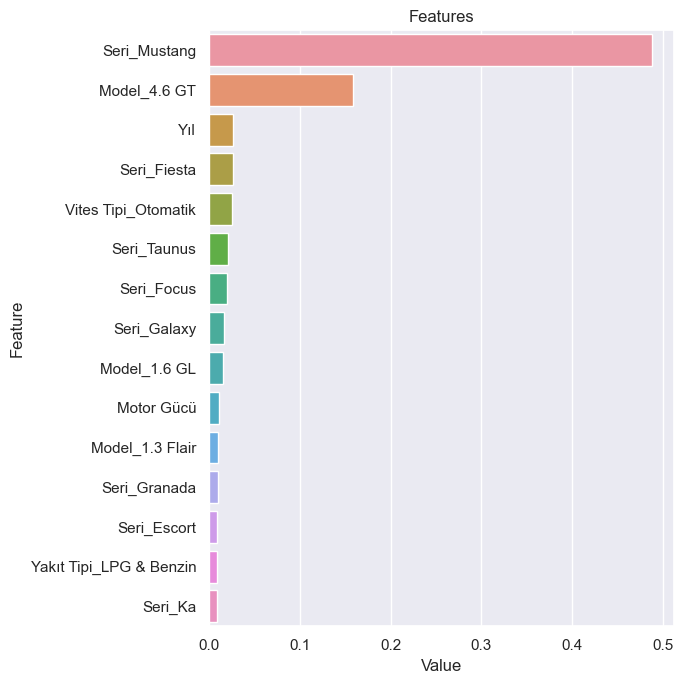

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)